# Direct Forecasting with Big Data in `forecastML`
### *Nick Redell* nickalusredell@gmail.com
### 2020-04-13

***

# Purpose

* The goal of this notebook is to show an end-to-end example workflow for forecasting with big data in `forecastML`. This tutorial, however, is only one of many approaches for solving the big data forecasting problem.
  
  
* The focus will be on tips and gotchas along the way. Detailed information about this particular forecasting problem can be found in the package vignettes.
  
  
* This notebook should run from start to finish. I know that it can be frustrating when examples don't work, so if you get stuck somewhere along the way feel free to open an issue at [https://github.com/nredell/forecastML/issues](https://github.com/nredell/forecastML/issues), and we'll see if we can't figure it out.

# Problem

* "I would like to forecast with machine learning in `R`, but the data are too big to fit into memory."
  
  
* **Gotcha #1**: Even if the input dataset is not that large, direct forecasting in `forecastML` can quickly reach the big data regime based on the following:
   + *Number of direct forecast horizons*: Because a unique dataset is created to train a unique ML model at each direct forecast horizon, 12 direct horizons, for example, will produce 12 datasets with `create_lagged_df()`. Here, a quick fix would be to make 12 calls to `create_lagged_df()`, save the files to disk with `save(lagged_df_h, file = "lagged_df_h.Rda")`, and `load(file = "lagged_df_h.Rda")` them as needed--and subsequently make 12 calls to `train_model()` and finally combine the results with `combine_forecasts()`. We won't be doing that here.
   + *Number of feature lags*: Each feature lag will create a new column in the dataset.

# Solution in this Notebook

* `Apache Spark` + `H2O` + `forecastML` with `create_skeleton()`.

# Example: Direct Forecasting with Big Data

***
## `R` Setup

In [2]:
options(warn = -1)
options(repr.plot.width = 12, repr.plot.height = 6)

library(readr)
library(dplyr)
library(ggplot2)
library(pryr)  # For measuring object sizes in memory.
library(DT)
library(forecastML)  # v0.9.0
library(h2o)  # v3.30.0.1
library(rsparkling)  # v3.30.0.1.1.2.4; the R interface to H2O's Sparkling Water.
library(sparklyr)  # v1.1.0; the R interface to Spark.

***
## Spark & H2O Setup in `R`

* **Spark**
    + Check out the following resources to learn more about the `sparklyr` `R` interface with Spark:
        + Thanks to [RStudio](https://rstudio.com), getting set up with Spark is super simple: https://spark.rstudio.com/.
        + Also, check out the `sparklyr` companion book: https://therinspark.com/

In [3]:
conf <- spark_config()
conf["spark.executor.memory"] <- "8g"
conf["sparklyr.shell.driver-memory"] <- "8g"
sc <- sparklyr::spark_connect(master = "local", version = "2.4.4", config = conf)  # Version 2.4+ needed.

* **H2O with Sparking Water**
    + [rsparkling](http://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/rsparkling.html) is the `R` interface to [H2O's](https://www.h2o.ai) Sparking Water which is H2O's interface with 
    [Apache Spark](https://spark.apache.org/).
    + **Gotcha #2:** H2O sits in the same JVM as Spark so any memory configurations should occur within Spark like we see above ([details](http://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/configuration/memory_setup.html)). This is different than a non-Spark H2O setup with 
    `h2o::h2o.init()`.

In [5]:
h2oConf <- rsparkling::H2OConf()
hc <- rsparkling::H2OContext.getOrCreate(h2oConf)

***
## Data Preparation in `forecastML`

* Load the example data.

<p>

* This dataset is not that big, but with 1 dataset per direct forecast horizon and many lagged features, the output from `create_lagged_df()` can quickly turn a small dataset into several GB or several hundred GB.

In [6]:
data("data_buoy_gaps", package = "forecastML")

DT::datatable(head(data_buoy_gaps), options = list(scrollX = TRUE))

HTML widgets cannot be represented in plain text (need html)

### `forecastML::fill_gaps()`

In [7]:
# Fill gaps in data collection so that feature lags are temporally correct. 
# fill_gaps() will add rows to the dataset as needed.
data <- forecastML::fill_gaps(data_buoy_gaps, date_col = 1, frequency = '1 day', 
                              groups = 'buoy_id', static_features = c('lat', 'lon'))

# Fill in date information that is missing in the expanded dataset.
data$day <- lubridate::mday(data$date)
data$year <- lubridate::year(data$date)

### Plot time series

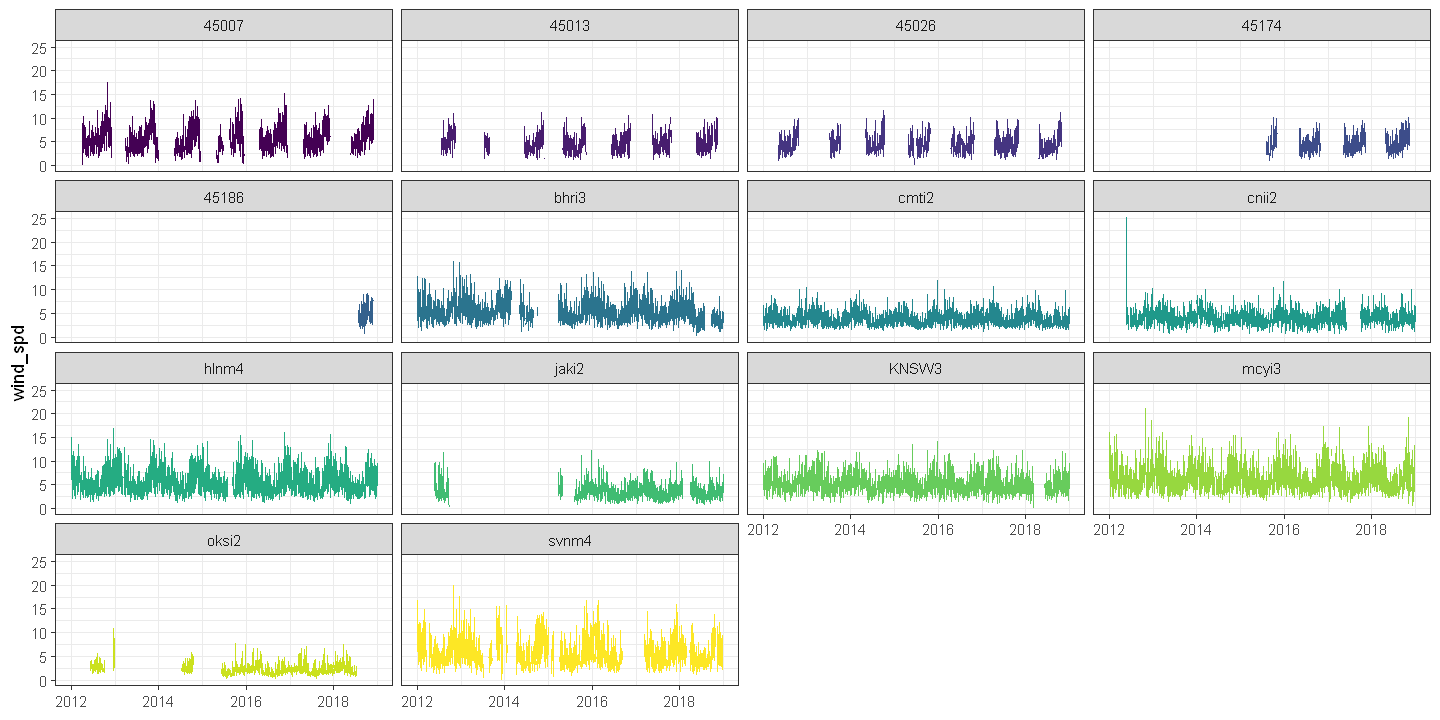

In [8]:
p <- ggplot(data, aes(x = date, y = wind_spd, color = ordered(buoy_id), group = year))
p <- p + geom_line()
p <- p + facet_wrap(~ ordered(buoy_id), scales = "fixed")
p <- p + theme_bw() + theme(
  legend.position = "none"
) + xlab(NULL)
p

### `forecastML::create_lagged_df()`

In [9]:
outcome_col <- 1  # The column position of our 'wind_spd' outcome (after removing the 'date' column).

type <- "train"  # Create a model-training dataset.

horizons <- c(1, 7, 30)  # Forecast 1, 1:7, and 1:30 days into the future.

lookback <- c(1:30, 360:370)  # Features from 1 to 30 days in the past and annually.

dates <- data$date  # Grouped time series forecasting requires dates.
data$date <- NULL  # Dates, however, don't need to be in the input data.

frequency <- "1 day"  # A string that works in base::seq(..., by = "frequency").

dynamic_features <- c("day", "year")  # Features that change through time but which will not be lagged.

groups <- "buoy_id"  # 1 forecast for each group or buoy.

static_features <- c("lat", "lon")  # Features that do not change through time.

data_train <- forecastML::create_lagged_df(data, type = type, outcome_col = outcome_col,
                                           horizons = horizons, lookback = lookback,
                                           dates = dates, frequency = frequency,
                                           dynamic_features = dynamic_features,
                                           groups = groups, static_features = static_features
                                           )

DT::datatable(head(data_train$horizon_1), options = list(scrollX = TRUE))  # View the horizon-1 dataset.

HTML widgets cannot be represented in plain text (need html)

### `forecastML::create_skeleton()`

* The general big data workflow in `forecastML` is
    1. Save data from `create_lagged_df()` outside of `R`.
    2. Run `create_skeleton()` on the model training data to save only the meta-data from `create_lagged_df()`.
    3. Read data from disk/database/Spark within the wrapper function passed in `train_model()`.
  
  
* First, let's take stock of our dataset sizes.

In [10]:
paste("The input data is: ", capture.output(pryr::object_size(data)))
paste("The output data from create_lagged_df() is: ", capture.output(pryr::object_size(data_train)))
paste("This is a ", trunc(as.numeric(pryr::object_size(data_train) / pryr::object_size(data))), "-fold increase in size.")

[1] "The input data is:  1.88 MB"

[1] "The output data from create_lagged_df() is:  67.7 MB"

[1] "This is a  36 -fold increase in size."

* Let's save the modeling datasets to disk before we free up memory in `R`.
  
  
* Because we're using Spark's RDD datasets which will shuffle the data, we're going to add an `index` to the data so that we can select the correct training and external validation datasets in `train_model()`. The column name doesn't have to be `index`, but setting it to `1:nrow(data)` is required if we want to correctly filter out any external validation windows. We'll remove it prior to model training.

In [11]:
for (i in seq_along(data_train)) {  # Save our 3 training datasets.
  # 1:nrow() for easier indexing later.
  data_train[[i]]$index <- 1:nrow(data_train[[i]])
  # Save just the data as "horizon_h.csv").
  readr::write_csv(data_train[[i]], paste0(names(data_train)[i], ".csv"))
}

* Spark-specific: Let's save a schema for each dataset so that we can load it into Spark quickly.

In [12]:
spark_schema <- lapply(data_train, function(x) {sapply(x, class)})  # A nested list of Spark schemas.

In [13]:
data_train <- forecastML::create_skeleton(data_train)  # Keeps the outcome, any groups, and meta-data.

paste("The output data from create_skeleton() is: ", capture.output(pryr::object_size(data_train)))

[1] "The output data from create_skeleton() is:  881 kB"

### `forecastML::create_windows()`

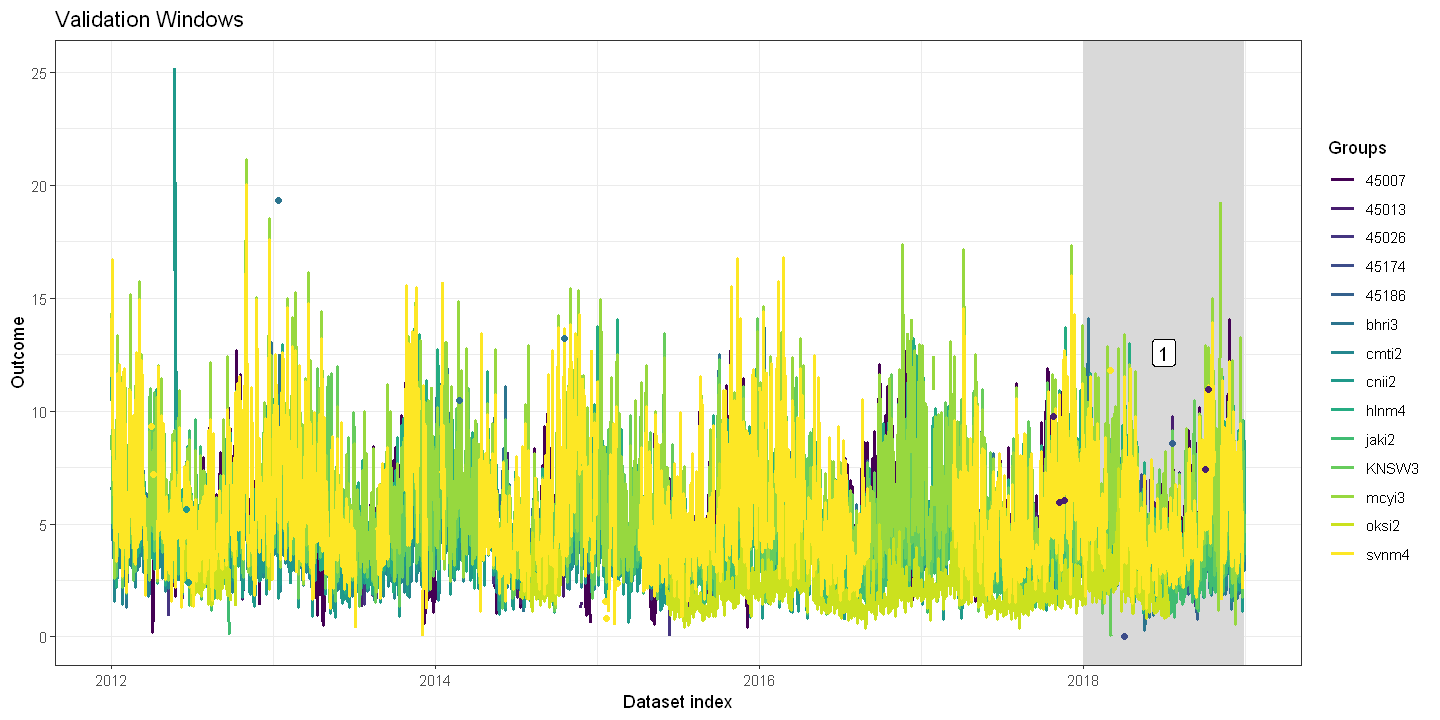

In [14]:
windows <- forecastML::create_windows(data_train,
                                      window_length = 0,  # A window that spans from start to stop.
                                      window_start = as.Date("2018-01-01"),  # Start of validation data.
                                      window_stop = as.Date("2018-12-31")  # End of validation data.
                                      )

plot(windows, data_train)

### Load data from disk to Spark

* We'll keep the data on disk with Spark and not cached in `R` because we're pretending that it cannot fit into memory.
  
  
* This should only take a few seconds.
  
  
* **Gotcha #3:** When reading data from outside of `R` into Spark, by default, any row with at least 1 missing value will 
be loaded into Spark with the entire row set to missing! This will throw our indexing off because the `index` column will be `NA` so we need to set `null_value = NA` in any of `sparklyr`'s data loading functions (e.g., `sparklyr::spark_read_csv()`).

In [15]:
for (i in seq_along(data_train)) {
    
    # Dynamically Assign each forecastML data.frame in .csv format to a Spark table in the global environment.
    # Similar to "horizon_1 <- lagged_df[[1]]", "horizon_7 <- lagged_df[[2]]", etc.
    base::assign(paste0("horizon_", horizons[i]),
                 
                     sparklyr::spark_read_csv(sc,  # Our Spark context from earlier.
                             path = paste0("horizon_", horizons[i], ".csv"),  # Name on disk.
                             columns = spark_schema[[i]],  # Horizon-specific data schema.
                             null_value = NA,  # Gotcha #3.
                             memory = FALSE,  # In-memory is quicker, but we're memory-constrained.
                             overwrite = TRUE,
                             repartition = 8  # Number of chunked sub-datasets. Will randomize rows.
                             )
                 )  # End assign().
}

***
## Modeling in `forecastML`

* Normally, the dataset, `data`, passed internally from `train_model()` to the custom function below is a dataset with the outcome and all model features. However, `data` is now a skeleton, and we have our datasets stored in Spark so we only need `data` to get key attributes which identify which dataset--correct horizon and validation window--we should train on.
  
  
* **Gotcha #4:** This is an `h2o`-specific feature that may unexpectedly increase memory usage (below). It isn't mentioned in the `R` docs, but you can find it in the documentation for [PySparkling](http://docs.h2o.ai/sparkling-water/2.1/latest-stable/doc/pysparkling.html):

> "To leverage H2O’s algorithms, data in Spark cluster, stored as an RDD or Dataset/Dataframe, needs to be converted to an H2OFrame (H2O’s distributed data frame). This requires a data copy because of the difference in data layout in Spark (blocks/rows) and H2O (columns). But as data is stored in H2O in a highly compressed format, the overhead of making a data copy is low."

### Custom model training function

In [16]:
model_function <- function(data) {  # Doesn't have to be "data" but should be the same throughout.
    
  # Will cycle from 1 to 7 to 30 in this example as each model is trained in turn.
  model_horizon <- attributes(data)$horizon
  # External validation windows that we DO NOT want to train on.
  validation_indices <- attributes(data)$validation_indices
  
  if (model_horizon == 1) {
      # Create a Spark table that h2o can convert to an H2OFrame.
      data_spark_train <- dplyr::tbl(sc, "horizon_1")
  
  } else if (model_horizon == 7) {
      
      data_spark_train <- dplyr::tbl(sc, "horizon_7")
      
  } else if (model_horizon == 30) {
      
      data_spark_train <- dplyr::tbl(sc, "horizon_30")
  }
    
  data_spark_train <- data_spark_train %>%
    dplyr::filter(!index %in%  !!validation_indices) %>%  # Remove validation data.
    dplyr::select(-index)  # Remove the index prior to training.
    
  # Convert Spark RDD to a Sparkling Water H2OFrame. Consumes memory.
  data_spark_train_h2o <- hc$asH2OFrame(data_spark_train)

  rm(model_horizon, validation_indices)  # Free memory.
      
  data_spark_train_h2o_split <- h2o::h2o.splitFrame(data_spark_train_h2o, 
                                                    ratios = 0.75, seed = 1)
  
  # Using H2O's standard library of algorithms.
  model_h2o_gbm <- h2o::h2o.gbm(y = 1,  # Outcome column position.
                                training_frame = data_spark_train_h2o_split[[1]],
                                validation_frame = data_spark_train_h2o_split[[2]],
                                ntrees = 300,
                                stopping_rounds = 3,
                                seed = 1)
    
  # We could return a named list with the model and any hyperparameters, but H20 
  # already stores most parameters internally in the trained model object.
  return(model_h2o_gbm)  
}

### `forecastML::train_model()`

* This should take ~30 seconds with this size data.

In [17]:
model_results_cv <- forecastML::train_model(data_train,  # This is a skeleton object.
                                            windows = windows,
                                            model_name = "h2o_gbm",  # This name can be whatever.
                                            model_function = model_function
                                            )

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Custom prediction function

* We'll use similar logic with respect to reading in the Spark datasets, converting to H2OFrames, and filtering. The difference 
is that **here we're selecting the data inside the validation window(s) for prediction**.
  
  
* Also, for prediction with skeleton objects, we'll have to manually remove the outcome column from the data that we read in.

In [18]:
prediction_function <- function(model, data) {  # forecastML will automatically pass the correct trained model.
    
  outcome_name <- "wind_spd"
  model_horizon <- attributes(data)$horizon
  validation_indices <- attributes(data)$validation_indices
  
  if (model_horizon == 1) {
    
      data_spark_valid <- dplyr::tbl(sc, "horizon_1")
  
  } else if (model_horizon == 7) {
      
      data_spark_valid <- dplyr::tbl(sc, "horizon_7")
      
  } else if (model_horizon == 30) {
      
      data_spark_valid <- dplyr::tbl(sc, "horizon_30")
  }
    
  data_spark_valid <- data_spark_valid %>%
      dplyr::filter(index %in%  !!validation_indices) %>%  # Keep validation data.
      dplyr::select(-!!outcome_name, -index)
    
  # Convert Spark RDD to a Sparkling Water H2OFrame. Consumes memory.
  data_spark_valid_h2o <- hc$asH2OFrame(data_spark_valid)

  rm(model_horizon, validation_indices)  # Free memory.

  # At present, forecastML requires that a data.frame of predictions is returned from this function. 
  # Calling as.data.frame() here is going to bring the data into R so make sure there's enough memory free 
  # for an nrow(validation data) by 1-column data.frame (or 3 columns if forecast intervals are returned).
  data_pred <- as.data.frame(h2o::h2o.predict(model, newdata = data_spark_valid_h2o))
  return(data_pred)
}

### `forecastML::predict()`

* This should take a few seconds with this size data.

In [19]:
# "_cv" acknowledges that these are historical predictions on external cross-validation windows.
data_pred_cv <- predict(model_results_cv, prediction_function = list(prediction_function), 
                        data = data_train)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### Plot historical predictions

* The top plot shows all group predictions for the 1 external validation window.
  
  
* The bottom plot shows predictions for 1 group at each direct forecast horizon.

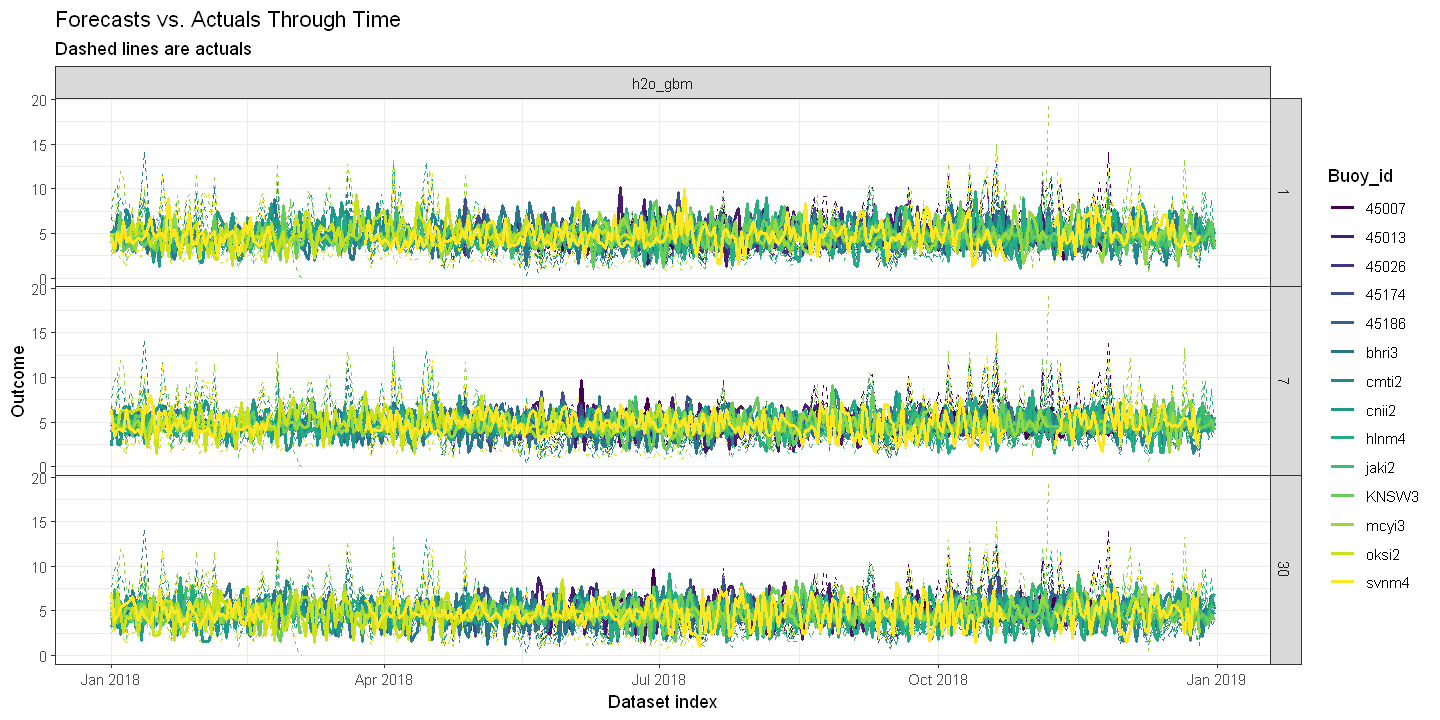

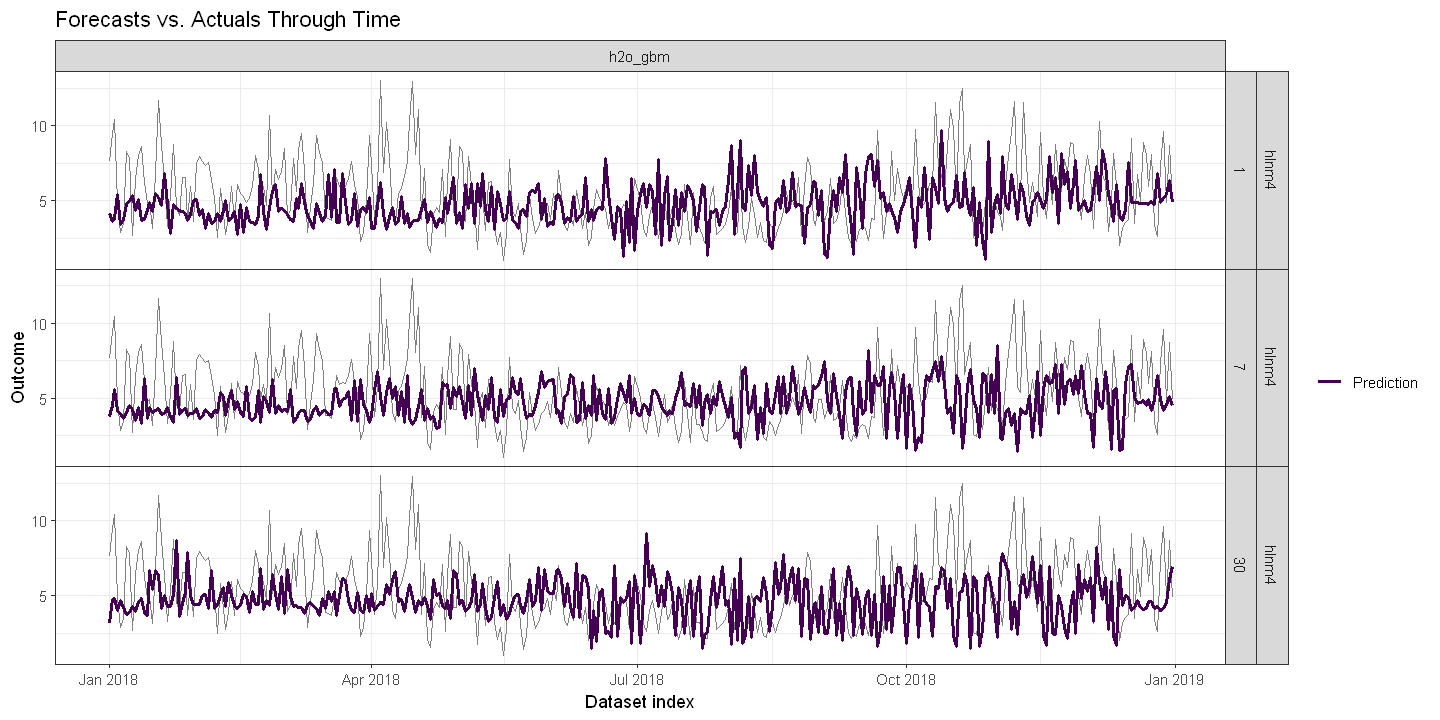

In [20]:
plot(data_pred_cv)
plot(data_pred_cv, facet = group + horizon ~ model, group_filter = "buoy_id %in% c('hlnm4')")

***
## `forecastML::return_error()`

* A note about forecasting with groups: Error metrics are calculated at the lowest level (e.g., a prediction/forecast at (a) a specific validation window at (b) a specific direct forecast horizon for (c) a specifc group is the most granual time series prediction) and then aggregated using the `aggregate = fun` argument.

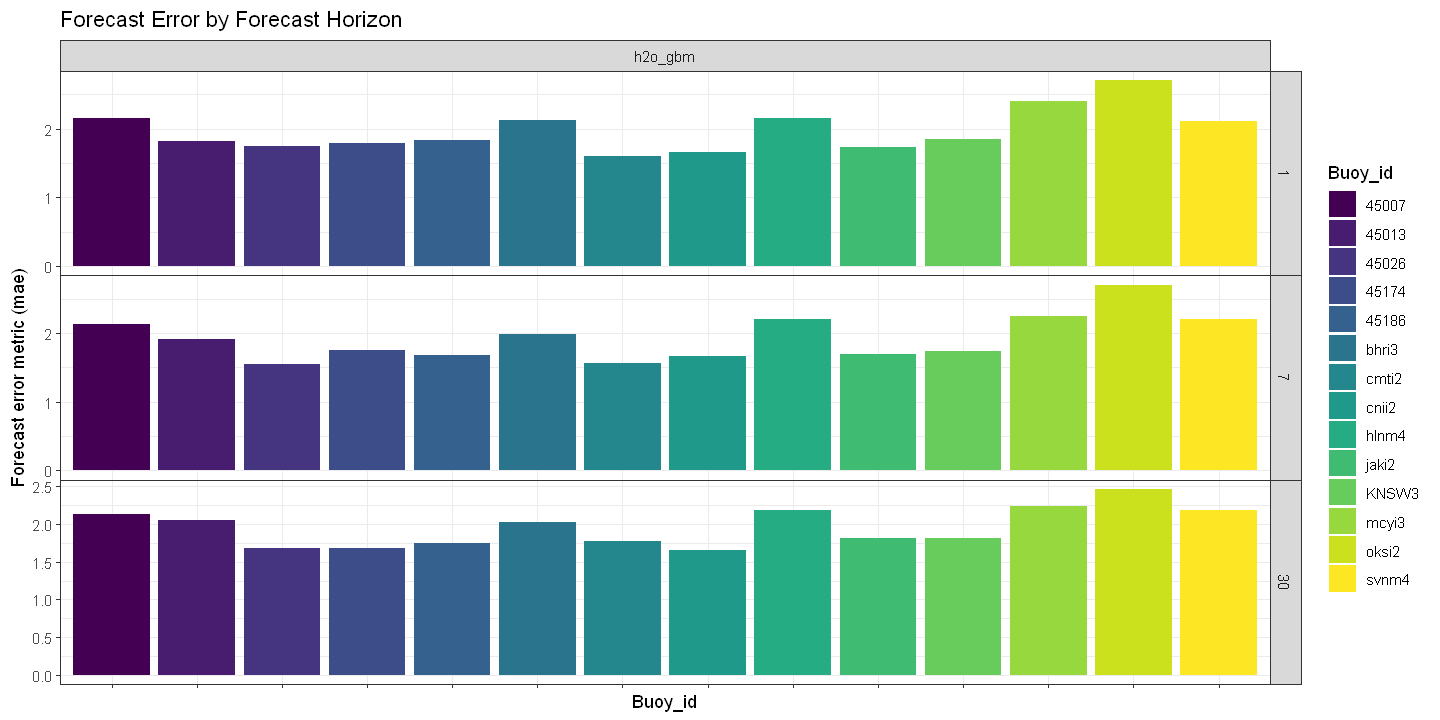

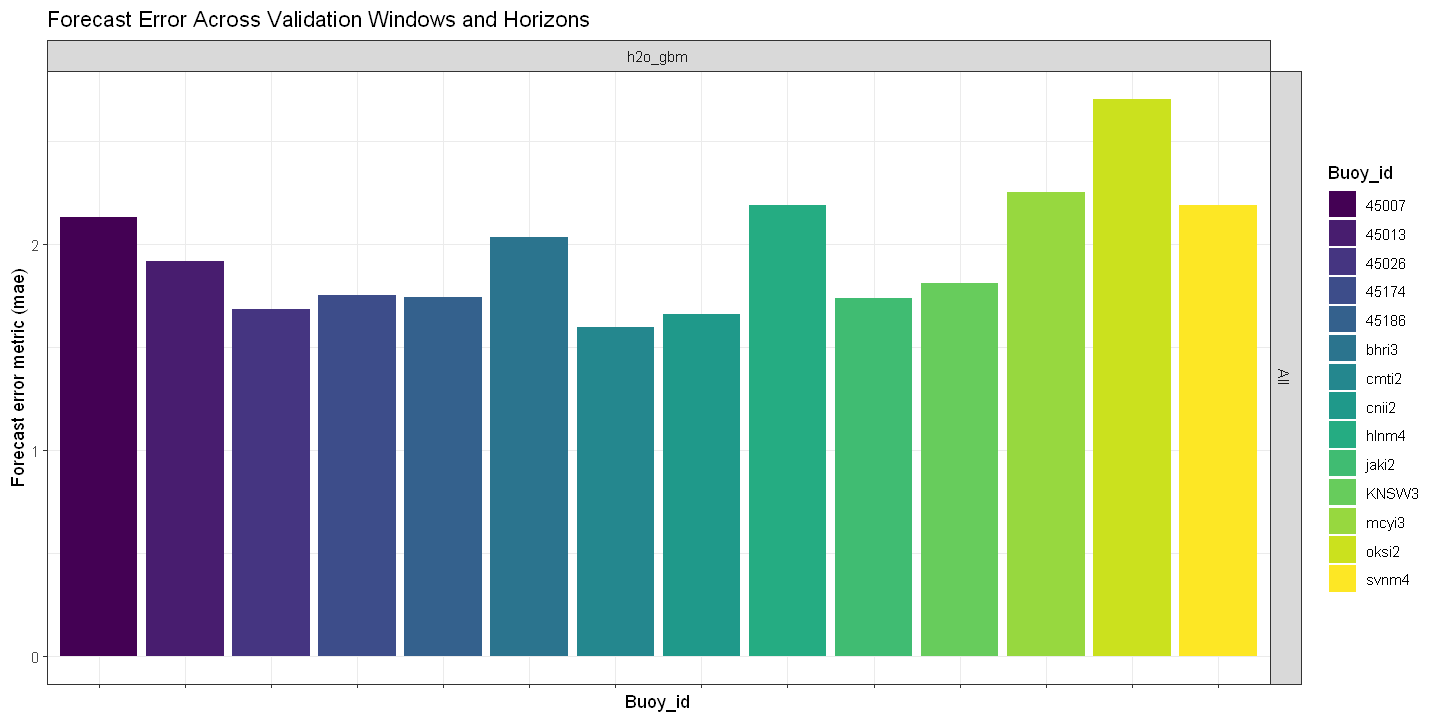

In [21]:
data_error <- forecastML::return_error(data_pred_cv, aggregate = stats::median)

plot(data_error, type = "horizon", metric = "mae")  # With 1 validation window, these metrics are the lowest level.
plot(data_error, type = "global", metric = "mae")  # Error aggregated across direct forecast horizons.

***
## Forecast in `forecastML`

* At present, skeleton datasets are not available for forecasting. Forecast datasets are typically far smaller than training datasets; however, skeleton functionality will likely extend to forecast datasets in the future.

In [22]:
type <- "forecast"  # Create a forecasting dataset for our forecast() function.

data_forecast <- forecastML::create_lagged_df(data, type = type, outcome_col = outcome_col,
                                              horizons = horizons, lookback = lookback,
                                              dates = dates, frequency = frequency,
                                              dynamic_features = dynamic_features,
                                              groups = groups, static_features = static_features, 
                                              use_future = FALSE)

# Fill in missing future values for dynamic, non-lagged features. 
# These values won't always be known, but date-based features are deterministic.
for (i in seq_along(data_forecast)) {
  data_forecast[[i]]$day <- lubridate::mday(data_forecast[[i]]$index)
  data_forecast[[i]]$year <- lubridate::year(data_forecast[[i]]$index)
}

DT::datatable(head(data_forecast$horizon_1), options = list(scrollX = TRUE))

HTML widgets cannot be represented in plain text (need html)

* The forecast datasets are stored in memory in `R` so we'll make a new, simpler prediction function that doesn't involve Spark.

In [23]:
forecast_function <- function(model, data) {  # forecastML will pass the correct trained model.

  data <- h2o::as.h2o(data)  # Convert an R dataset to an H2O dataframe. Consumes memory.
    
  data_pred <- as.data.frame(h2o::h2o.predict(model, newdata = data))
  return(data_pred)
}

In [24]:
data_forecasts <- predict(model_results_cv, prediction_function = list(forecast_function), 
                          data = data_forecast)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


* If we had trained on multiple validation windows, each group would have a unique forecast for each combination of window and direct forecast horizon. If we like these results, we'll take the final step of retraining on all data and producing a final forecast for each group with `combine_forecasts()`.

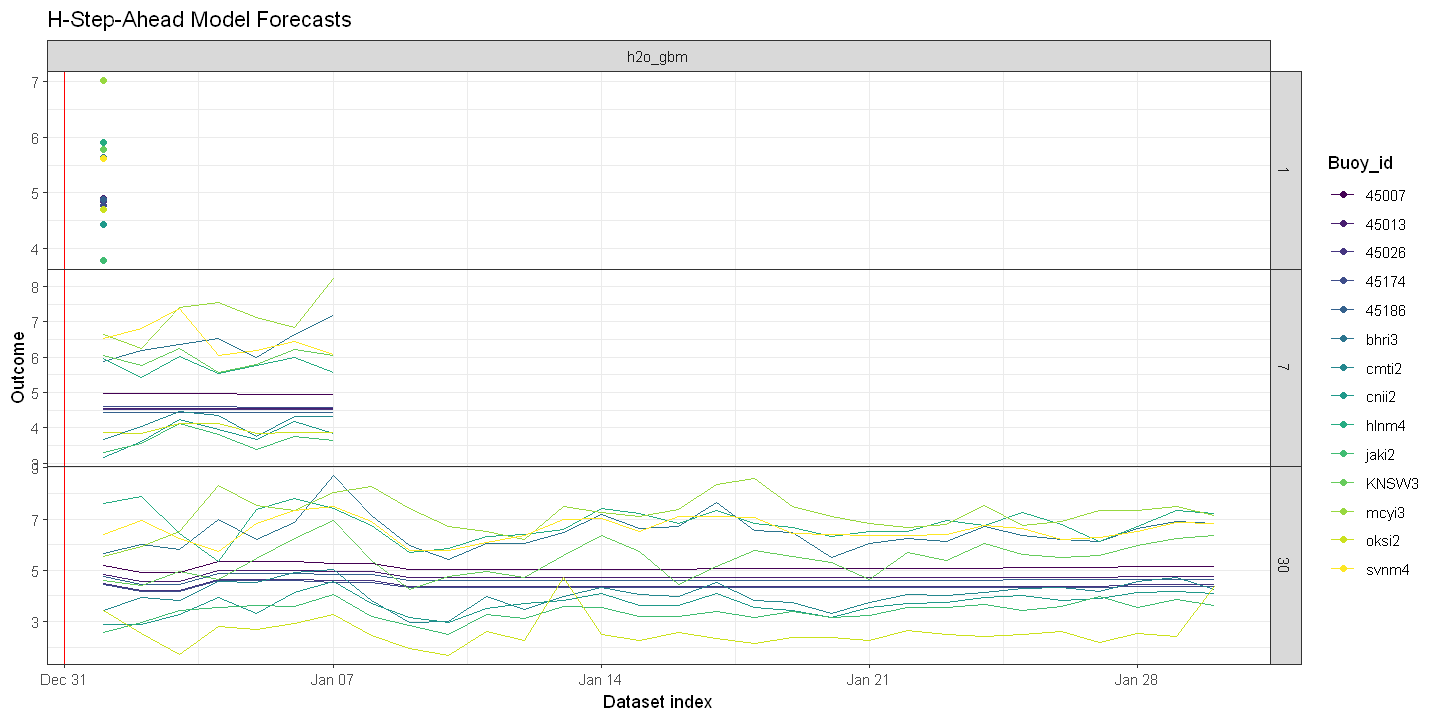

In [25]:
plot(data_forecasts)

***
## Retrain with All Data & Produce Final Forecasts

* At this point, in the real world we would have selected the best models and hyperparameters based on the forecast error on the external validation datasets/windows.
  
  
* Set `create_windows(..., window_length = 0)` to train over all data. Historical predictions will essentially produce fit statistics.

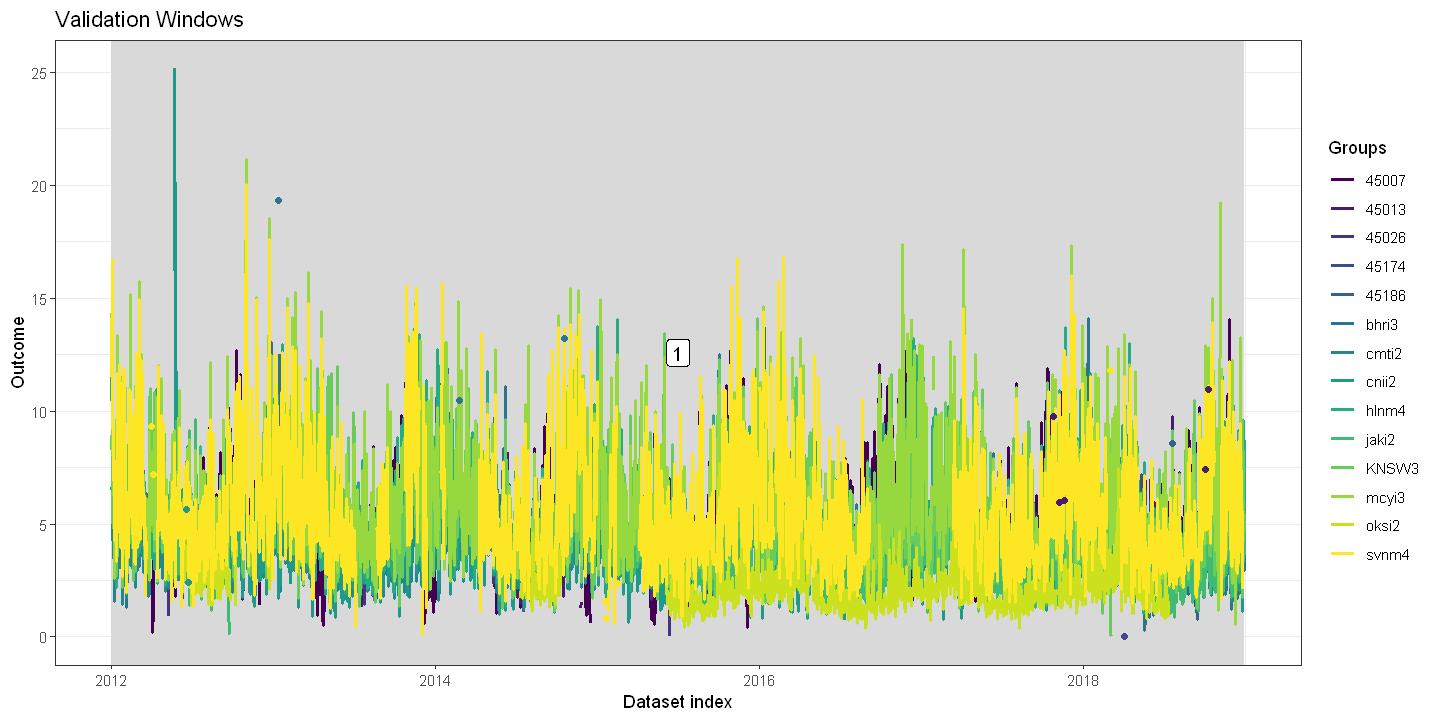

In [26]:
windows <- forecastML::create_windows(data_train, window_length = 0)

plot(windows, data_train)

### Custom model training and predict functions

* In the non-big-data case, it'd be quick to simply re-use our custom functions from earlier. However, in those functions we filtered to remove (`train()`) or select (`predict()`) validation data. Here, we're training and predicting on all historical data so we'll re-define these functions without this filtering.
  
  
* Note that, while we create a new prediction function below for the sake of illustraion, we'll skip predicting on the historical data--model fit with `window_length = 0`--and will instead go straight to forecasting.

In [27]:
model_function <- function(data) {
  
  model_horizon <- attributes(data)$horizon
    
  if (model_horizon == 1) {
    
      data_spark_train <- dplyr::tbl(sc, "horizon_1")
      n_trees <- 300  # Optimal hyperparameter learned from model exploration.
      
  } else if (model_horizon == 7) {
      
      data_spark_train <- dplyr::tbl(sc, "horizon_7")
      n_trees <- 43
      
  } else if (model_horizon == 30) {
      
      data_spark_train <- dplyr::tbl(sc, "horizon_30")
      n_trees <- 70
  }
    
  data_spark_train <- data_spark_train %>%
    dplyr::select(-index)

  data_spark_train_h2o <- hc$asH2OFrame(data_spark_train)
    
  # Note that there is no validation frame because we have already learned the 
  # optimal hyperparameters (in reality, hyperparameter tuning is much more extensive).
  model_h2o_gbm <- h2o::h2o.gbm(y = 1
                                training_frame = data_spark_train_h2o,
                                ntrees = n_trees,
                                seed = 1)
      
  return(model_h2o_gbm)
}
#----------------------------------------------------------------------------
prediction_function <- function(model, data) {
    
  outcome_name <- "wind_spd"  # This is auto-removed in the non-skeleton, non-big-data case.
  model_horizon <- attributes(data)$horizon
  
  if (model_horizon == 1) {
    
      data_spark_valid <- dplyr::tbl(sc, "horizon_1")
  
  } else if (model_horizon == 7) {
      
      data_spark_valid <- dplyr::tbl(sc, "horizon_7")
      
  } else if (model_horizon == 30) {
      
      data_spark_valid <- dplyr::tbl(sc, "horizon_30")
  }
    
  data_spark_valid <- data_spark_valid %>%
      dplyr::select(-!!outcome_name, -index)

  data_spark_valid_h2o <- hc$asH2OFrame(data_spark_valid)
    
  data_pred <- as.data.frame(h2o::h2o.predict(model, newdata = data_spark_valid_h2o))
  return(data_pred)
}

* Train on all the data.

In [28]:
model_results_no_cv <- forecastML::train_model(data_train,  # The same skeleton object.
                                               windows = windows,
                                               model_name = "h2o_gbm",
                                               model_function = model_function
                                               )

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


* Forecast into the future.

In [29]:
data_forecasts <- predict(model_results_no_cv, prediction_function = list(forecast_function), 
                          data = data_forecast)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


### `forecastML::combine_forecasts()`

* Check out the [forecast combination vignette](https://nredell.github.io/forecastML/doc/combine_forecasts) for various combination strategies.
  
  
* The final predictions below aren't that great. Better model selection, additional hyperparameter tuning, 
and feature engineering (e.g., selecting different lags) would be time well spent.
  
  
* Notice that we're still getting forecasts for buoys like 45007 that stopped collecting data a month or so 
before the forecast period. These forecasts are mostly flat because the lagged features don't have 
a long-lasting effect; however, our dynamic date features are carrying some signal and preventing the 
forecasts from beling completely flat.

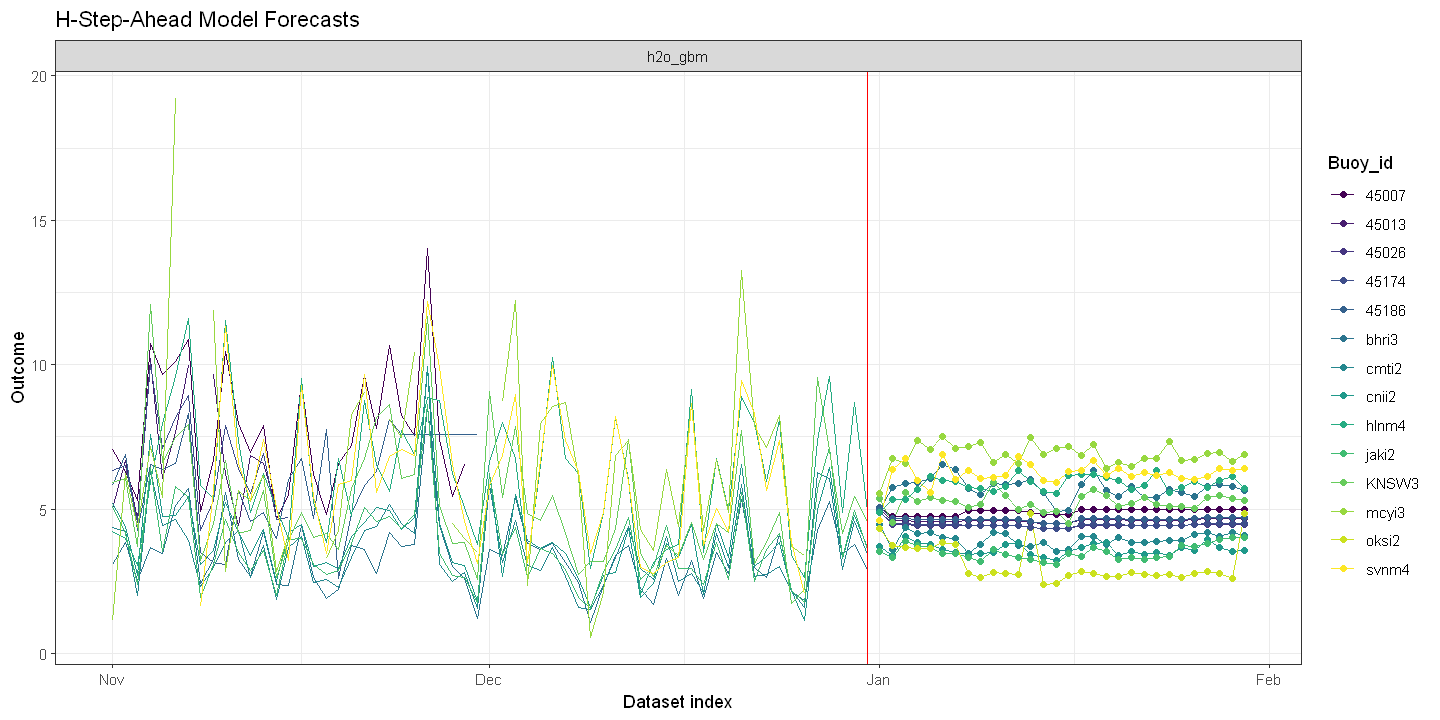

In [30]:
data_combined <- forecastML::combine_forecasts(data_forecasts)

# Plot a background dataset of actuals using the most recent data.
data_actual <- data[dates >= as.Date("2018-11-01"), ]
actual_indices <- dates[dates >= as.Date("2018-11-01")]

# Plot all final forecasts plus historical data.
plot(data_combined, data_actual = data_actual, actual_indices = actual_indices)

* If we had held out a true test dataset for January 2019, we could have checked our 
forecast accuracy here with `return_error(data_combined, data_test = ..., test_indices = ...)`.

In [31]:
# End our Spark session.
sparklyr::spark_disconnect(sc)